# A2Perf Metric Analysis


### Imports

In [3]:
!pip install tensorboard sns tbparse matplotlib pandas scipy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import glob
import os
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorboard as tb
from packaging import version
from scipy import stats
from tbparse import SummaryReader

2023-11-02 18:20:39.550837: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 18:20:39.708734: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 18:20:40.398080: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 18:20:40.398120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 18:20:40.402011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [5]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.14.1


## Load Data

In [6]:
base_dir = '/home/ikechukwuu/workspace/gcs/a2perf/'
debug = False

algo_to_exp_dict = dict(
    ppo='0006',
    ddpg='0025'
)
domain = 'quadruped_locomotion'
task = 'dog_pace'

seeds_to_process = [37, 14, 82,
                    23, 65, 98
                    ]

In [126]:
log_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '', task)

for algo in algo_to_exp_dict.keys():
    experiment_path = os.path.join(experiment_base_dir, algo, algo_to_exp_dict[algo],
                                   f'**/tensorboard/{algo.upper()}_0_1/*events*')
    print(f'Experiment Path: {experiment_path}')

    log_dirs.extend(glob.glob(experiment_path, recursive=True))

log_dirs = [log_dir for log_dir in log_dirs if any([f'seed_{seed}' in log_dir for seed in seeds_to_process])]
log_dirs

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/**/tensorboard/PPO_0_1/*events*
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/**/tensorboard/DDPG_0_1/*events*


['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1698157099.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1698096445.locomotion-2',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_37_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1698096394.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_23_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1698157113.locomotion-1',
 '/home/ikechukwuu/workspace/gcs/a2p

In [127]:
print(len(log_dirs))

12


## Pack Data into DataFrame

In [128]:
def load_tb_data(event_file):
    iterations_data = dict()
    ep_rew_data = dict()

    for event in tf.compat.v1.train.summary_iterator(event_file):
        for value in event.summary.value:
            # Check for episode_reward in the event
            if value.tag == 'episode_reward':
                if event.step in ep_rew_data:
                    raise ValueError(f'Found duplicate episode_reward data for step: {event.step}')
                ep_rew_data[event.step] = value.simple_value

            # Check for iterations in the event
            if value.tag == 'iterations':
                if event.step in iterations_data:
                    raise ValueError(f'Found duplicate iterations data for step: {event.step}')
                iterations_data[event.step] = value.simple_value

    df = pd.DataFrame.from_dict(iterations_data, orient='index', columns=['iterations'])
    df['episode_reward'] = df['iterations'].map(ep_rew_data)
    df = df.reset_index()
    df = df.rename(columns={'index': 'step'})
    df = df.drop(columns=['iterations'])
    df['step'] = df['step'].astype(int)
    return df



In [129]:
all_df = pd.DataFrame()
for log_dir in log_dirs:
    log_base_dir = os.path.dirname(log_dir)
    exp_split = log_dir.split('/')

    exp_name = exp_split[-4]
    exp_name_split = exp_name.split('_')

    seed = exp_name_split[-5]
    experiment = exp_split[-5]
    algo = exp_split[-6]
    print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

    data = load_tb_data(log_dir)
    data['seed'] = seed
    data['experiment'] = experiment
    data['algo'] = algo

    print(f'\tSaving data.csv to {log_base_dir}')
    data.to_csv(os.path.join(log_base_dir, 'data.csv'))

    print(f'\tFinished processing {log_dir}')
    print(f'\tNumber of rows: {len(data)}')

    # Print out the last global step value
    print(f'\tLast global step value: {data["step"].iloc[-1]}')
    all_df = pd.concat([all_df, data])




Processing Experiment: 0006, Seed: 65, Algo: ppo
	Saving data.csv to /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1
	Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1698157099.locomotion-0
	Number of rows: 47059
	Last global step value: 47058
Processing Experiment: 0006, Seed: 14, Algo: ppo
	Saving data.csv to /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/tensorboard/PPO_0_1
	Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed

In [130]:
for algo in algo_to_exp_dict.keys():
    algo_df = all_df[all_df['algo'] == algo]
    print(f'Algo: {algo}, Number of rows: {len(algo_df)}')

    # also get number of seeds
    print(f'Number of seeds: {len(algo_df["seed"].unique())}')


Algo: ppo, Number of rows: 282354
Number of seeds: 6
Algo: ddpg, Number of rows: 280704
Number of seeds: 6


In [131]:
for algo in algo_to_exp_dict.keys():
    df = all_df[all_df['algo'] == algo]
    print(f'Algo: {algo}')
    for seed, group in df.groupby('seed'):
        print(f'\tSeed: {seed}')
        diff = group['step'].diff()
        print(f'\t\tMin diff: {diff.min()}')
        print(f'\t\tMax diff: {diff.max()}')
        print(f'\t\tMedian diff: {diff.median()}')
        print(f'\t\tMean diff: {diff.mean()}')

Algo: ppo
	Seed: 14
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 23
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 37
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 65
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 82
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 98
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
Algo: ddpg
	Seed: 14
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 23
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 37
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 65
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 82
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 98
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0


<Axes: xlabel='step', ylabel='episode_reward'>

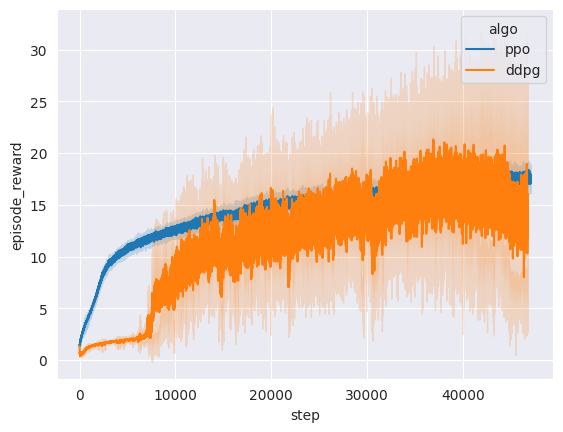

In [133]:
# plot both algorithms but group by the seeds to get mean and standard deviation
sns.lineplot(x='step', y='episode_reward', hue='algo', data=all_df, errorbar='sd')

### Computing Window Size

In [135]:
EVAL_POINTS_PER_WINDOW = 5
med_step_diffs = []
for algo in algo_to_exp_dict.keys():
    algo_df = all_df[all_df['algo'] == algo]
    algo_grouped = algo_df.groupby('seed')
    for seed, group in algo_grouped:
        mean_step_diff = group['step'].diff().mean()
        median_step_diff = group['step'].diff().median()
        window_size = int(EVAL_POINTS_PER_WINDOW * median_step_diff)
        print(f'Seed: {seed}')
        print(f'\tMean step difference: {mean_step_diff}')
        print(f'\tMedian step difference: {median_step_diff}')
        print(f'\tWindow size: {window_size}')
        med_step_diffs.append(median_step_diff)

Seed: 14
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 23
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 37
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 65
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 82
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 98
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 14
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 23
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 37
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 65
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 82
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 98
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5


In [136]:
window_size = int(EVAL_POINTS_PER_WINDOW * np.mean(med_step_diffs))
avg_step_diff = int(np.mean(med_step_diffs))
window_size, avg_step_diff

(5, 1)

### Computing Reliability Metrics

In [137]:
eval_points = list(range(np.ceil(window_size / 2).astype(int), max(all_df['step']), avg_step_diff))
eval_points


[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,


In [148]:
# window_fn = stats.iqr
# 
# for algo in algo_to_exp_dict.keys():
#     all_mean_iqr_values = []
#     all_std_iqr_values = []
#     all_iqr_values = []
#     number_valid_eval_points = []
# 
#     print(f'Processing algo: {algo}')
#     algo_filtered_df = all_df[all_df['algo'] == algo]
#     for seed in seeds_to_process:
#         windows_to_evaluate = []
#         print(f'\tProcessing seed: {seed}')
#         seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == str(seed)].copy()
#         seed_filtered_df['episode_reward_diff'] = seed_filtered_df['episode_reward'].diff()
#         seed_filtered_df = seed_filtered_df[['step', 'episode_reward_diff']]
#         seed_filtered_df = seed_filtered_df.dropna()
#         print('\t\tNumber of rows: ', len(seed_filtered_df))
#         steps, episode_reward_diff = seed_filtered_df.to_numpy().T
#         for eval_point in eval_points:
#             low_end = np.ceil(eval_point - (window_size / 2))
#             high_end = np.floor(eval_point + (window_size / 2))
# 
#             eval_points_above = steps >= low_end
#             eval_points_below = steps <= high_end
#             eval_points_in_window = np.logical_and(eval_points_above, eval_points_below)
#             valid_eval_points = np.nonzero(eval_points_in_window)[0]
# 
#             if len(valid_eval_points) == 0:
#                 print(f'\t\tNo valid eval points for eval point: {eval_point}')
#                 print(f'Stopping since that means current seed is done')
#                 break
#                 
#             number_valid_eval_points.append(len(valid_eval_points))
#             windows_to_evaluate.append(valid_eval_points)
#         iqr_values = [window_fn(episode_reward_diff[window]) for window in windows_to_evaluate]
#         mean_iqr = np.mean(iqr_values)
#         median_iqr = np.median(iqr_values)
#         print(f'\t\tOn average there were {np.mean(number_valid_eval_points)} valid eval points per window')
#         print(f'\t\tMean IQR: {mean_iqr} +/- {np.std(iqr_values)}')
#         print(f'\t\tMedian IQR: {median_iqr}')
# 
#         all_mean_iqr_values.append(mean_iqr)
#         all_std_iqr_values.append(np.std(iqr_values))
# 
#     print(f'\tAll mean iqr values: {all_mean_iqr_values}')
#     print(f'\tAverage mean iqr value: {np.mean(all_mean_iqr_values)} +/- {np.std(all_mean_iqr_values)}')


Processing algo: ddpg
	Processing seed: 37
		Number of rows:  46783
		No valid eval points for eval point: 46786
Stopping since that means current seed is done
		On average there were 4.9997862471410555 valid eval points per window
		Mean IQR: 1.8511042653790644 +/- 1.505771449636065
		Median IQR: 1.6166906356811523
	Processing seed: 14
		Number of rows:  46783
		No valid eval points for eval point: 46786
Stopping since that means current seed is done
		On average there were 4.9997862471410555 valid eval points per window
		Mean IQR: 2.068656467469058 +/- 1.900878536135301
		Median IQR: 1.6616077423095703
	Processing seed: 82
		Number of rows:  46783
		No valid eval points for eval point: 46786
Stopping since that means current seed is done
		On average there were 4.9997862471410555 valid eval points per window
		Mean IQR: 4.2345832003708885 +/- 3.8454713742183415
		Median IQR: 3.5579795837402344
	Processing seed: 23
		Number of rows:  46783
		No valid eval points for eval point: 46786

In [223]:
window_fn = stats.iqr

for algo in algo_to_exp_dict.keys():
    all_iqr_values = []
    number_valid_eval_points = []

    print(f'Processing algo: {algo}')
    algo_filtered_df = all_df[all_df['algo'] == algo]
    for seed in seeds_to_process:
        windows_to_evaluate = []
        print(f'\tProcessing seed: {seed}')
        seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == str(seed)].copy()
        seed_filtered_df['episode_reward_diff'] = seed_filtered_df['episode_reward'].diff()
        seed_filtered_df = seed_filtered_df[['step', 'episode_reward_diff']]
        seed_filtered_df = seed_filtered_df.dropna()
        print('\t\tNumber of rows: ', len(seed_filtered_df))
        steps, episode_reward_diff = seed_filtered_df.to_numpy().T
        for eval_point in eval_points:
            low_end = np.ceil(eval_point - (window_size / 2))
            high_end = np.floor(eval_point + (window_size / 2))

            eval_points_above = steps >= low_end
            eval_points_below = steps <= high_end
            eval_points_in_window = np.logical_and(eval_points_above, eval_points_below)
            valid_eval_points = np.nonzero(eval_points_in_window)[0]

            if len(valid_eval_points) == 0:
                # print(f'\t\tNo valid eval points for eval point: {eval_point}')
                # print(f'Stopping since that means current seed is done')
                break

            number_valid_eval_points.append(len(valid_eval_points))
            windows_to_evaluate.append(valid_eval_points)
        iqr_values = [window_fn(episode_reward_diff[window]) for window in windows_to_evaluate]
        all_iqr_values.extend(iqr_values)
        # print(f'\t\tOn average there were {np.mean(number_valid_eval_points)} valid eval points per window')
        # print(f'\t\tMean IQR: {mean_iqr} +/- {np.std(iqr_values)}')
        # print(f'\t\tMedian IQR: {median_iqr}')

    print(f'\tAll mean iqr values: {np.mean(all_iqr_values)} +/- {np.std(all_iqr_values)}')


Processing algo: ppo
	Processing seed: 37
		Number of rows:  47058
	Processing seed: 14
		Number of rows:  47058
	Processing seed: 82
		Number of rows:  47058
	Processing seed: 23
		Number of rows:  47058
	Processing seed: 65
		Number of rows:  47058
	Processing seed: 98
		Number of rows:  47058
	All mean iqr values: 0.6404025417996767 +/- 0.4272473660427797
Processing algo: ddpg
	Processing seed: 37
		Number of rows:  46783
	Processing seed: 14
		Number of rows:  46783
	Processing seed: 82
		Number of rows:  46783
	Processing seed: 23
		Number of rows:  46783
	Processing seed: 65
		Number of rows:  46783
	Processing seed: 98
		Number of rows:  46783
	All mean iqr values: 3.0460042751314402 +/- 2.9352759306617484



##### Long-term risk across time
Long - term risk across time represents the propensity of the agent to crash after achieving a higher performance measure

In [150]:
def compute_drawdown(sequence):
    """Computes the drawdown for a sequence of numbers.

      The drawdown at time T is the decline from the highest peak occurring at or
      before time T. https://en.wikipedia.org/wiki/Drawdown_(economics).

      The drawdown is always non-negative. A larger (more positive) drawdown
      indicates a larger drop.

    Args:
      sequence: A numpy array.

    Returns:
      A numpy array of same length as the original sequence, containing the
        drawdown at each timestep.
    """
    peak_so_far = np.maximum.accumulate(sequence)
    return peak_so_far - sequence

In [158]:
alpha = 0.95

for algo in algo_to_exp_dict.keys():
    all_cvars = []
    all_drawdowns = []
    print(f'Processing algo: {algo}')
    algo_filtered_df = all_df[all_df['algo'] == algo]
    for seed in seeds_to_process:
        print(f'\tProcessing seed: {seed}')

        seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == str(seed)].copy()
        seed_filtered_df = seed_filtered_df.sort_values(by='step')
        # Compute the drawdowns
        episode_rewards = seed_filtered_df['episode_reward'].values
        drawdowns = compute_drawdown(episode_rewards)
        all_drawdowns.extend(drawdowns)
        # Get the bottom "alpha" percent of drawdowns (we use the 95th percentile to get the bottom 5% of drawdowns)
        top_alpha_percent = np.percentile(drawdowns, alpha * 100)

        # CVaR is the average of the bottom "alpha" percent of drawdowns
        # cvar = np.mean(drawdowns[drawdowns <= bottom_alpha_percent]) we actually need greater than
        cvar = np.mean(drawdowns[drawdowns >= top_alpha_percent])
        all_cvars.append(cvar)
        print(f'\t\tCVaR: {cvar}')

    #now show overall mean and std of all cvars
    print(f'\tAll CVaR values: {all_cvars}')
    print(f'\tAverage CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')

    # now compute the cvar of all drawdowns together
    all_drawdowns = np.array(all_drawdowns)
    top_alpha_percent = np.percentile(all_drawdowns, alpha * 100)
    cvar = np.mean(all_drawdowns[all_drawdowns >= top_alpha_percent])
    print(f'\tAll CVaR values: {cvar}')

Processing algo: ppo
	Processing seed: 37
		CVaR: 2.931427516685969
	Processing seed: 14
		CVaR: 3.1503845653379923
	Processing seed: 82
		CVaR: 3.0049485831984146
	Processing seed: 23
		CVaR: 3.1159330761995006
	Processing seed: 65
		CVaR: 3.137380873554066
	Processing seed: 98
		CVaR: 2.834605522577275
	All CVaR values: [2.931427516685969, 3.1503845653379923, 3.0049485831984146, 3.1159330761995006, 3.137380873554066, 2.834605522577275]
	Average CVaR value: 3.029113356258869 +/- 0.11685174517095022
	All CVaR values: 3.0441627153206654
Processing algo: ddpg
	Processing seed: 37
		CVaR: 8.739813243018256
	Processing seed: 14
		CVaR: 18.38433063901388
	Processing seed: 82
		CVaR: 23.06759529623211
	Processing seed: 23
		CVaR: 12.12918648393745
	Processing seed: 65
		CVaR: 22.649624312777295
	Processing seed: 98
		CVaR: 21.992646414347185
	All CVaR values: [8.739813243018256, 18.38433063901388, 23.06759529623211, 12.12918648393745, 22.649624312777295, 21.992646414347185]
	Average CVaR val

##### Short-term risk across time
Short - term risk across time represents how volatile the agent is from eval point to eval point

In [224]:
alpha = 0.05
for algo in algo_to_exp_dict.keys():
    all_cvars = []
    all_diffs = []
    print(f'Processing algo: {algo}')
    algo_filtered_df = all_df[all_df['algo'] == algo]
    for seed in seeds_to_process:
        print(f'\tProcessing seed: {seed}')

        seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == str(seed)].copy()
        seed_filtered_df = seed_filtered_df.sort_values(by='step')

        seed_filtered_df['episode_reward_diff'] = seed_filtered_df['episode_reward'].diff()
        seed_filtered_df = seed_filtered_df.dropna()

        episode_reward_diffs = seed_filtered_df['episode_reward_diff'].values
        all_diffs.extend(episode_reward_diffs)
        bottom_alpha_percent = np.percentile(episode_reward_diffs, alpha * 100, interpolation='linear')

        # CVaR is the average of the bottom "alpha" percent of diffs
        # cvar = np.mean(drawdowns[drawdowns <= top_alpha_percent])
        cvar = np.mean(episode_reward_diffs[episode_reward_diffs <= bottom_alpha_percent])
        all_cvars.append(cvar)
        print(f'\t\tCVaR: {cvar}')

    # Finally, report the mean and standard deviation of ALL the CVaR values in \pm notation
    print(f'\tAll CVaR values: {all_cvars}')
    print(f'\tAverage CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')

    # now compute the cvar of all diffs together
    all_diffs = np.array(all_diffs)
    bottom_alpha_percent = np.percentile(all_diffs, alpha * 100, interpolation='linear')
    cvar = np.mean(all_diffs[all_diffs <= bottom_alpha_percent])
    print(f'\tAll CVaR values: {cvar}')

Processing algo: ppo
	Processing seed: 37
		CVaR: -1.2231163595566787
	Processing seed: 14
		CVaR: -1.2349248049921573
	Processing seed: 82
		CVaR: -1.2492174054529634
	Processing seed: 23
		CVaR: -1.2920288960578032
	Processing seed: 65
		CVaR: -1.2961258805157831
	Processing seed: 98
		CVaR: -1.2377264798574128
	All CVaR values: [-1.2231163595566787, -1.2349248049921573, -1.2492174054529634, -1.2920288960578032, -1.2961258805157831, -1.2377264798574128]
	Average CVaR value: -1.2555233044054663 +/- 0.028320272440977304
	All CVaR values: -1.2561320651943748
Processing algo: ddpg
	Processing seed: 37
		CVaR: -4.193356613674735
	Processing seed: 14
		CVaR: -5.07676962387358
	Processing seed: 82
		CVaR: -10.131944081467442
	Processing seed: 23
		CVaR: -6.420707880024217
	Processing seed: 65
		CVaR: -10.026841072037689
	Processing seed: 98
		CVaR: -7.269907101759544
	All CVaR values: [-4.193356613674735, -5.07676962387358, -10.131944081467442, -6.420707880024217, -10.026841072037689, -7.26


##### Risk across runs
Risk across runs tells use how poor the final performance of the worst runs are

In [225]:
# Get the final episode reward for each seed
final_episode_rewards = all_df.groupby(['algo', 'seed']).tail(1)
final_episode_rewards

,step,episode_reward,seed,experiment,algo
47058,47058,18.118282,65,0006,ppo
47058,47058,18.170876,14,0006,ppo
47058,47058,17.434828,37,0006,ppo
47058,47058,18.715052,23,0006,ppo
47058,47058,18.539644,82,0006,ppo
47058,47058,16.759602,98,0006,ppo
46783,46783,26.492647,65,0025,ddpg
46783,46783,4.140475,98,0025,ddpg
46783,46783,17.735746,23,0025,ddpg
46783,46783,9.503802,37,0025,ddpg


In [226]:
# Compute the CVaR of final episode rewards for each algo
alpha = 0.05
for algo in algo_to_exp_dict.keys():
    algo_final_episode_rewards = final_episode_rewards[final_episode_rewards['algo'] == algo]
    top_alpha_percent = np.percentile(algo_final_episode_rewards['episode_reward'].values, alpha * 100,
                                      interpolation='linear')
    cvar = np.mean(algo_final_episode_rewards['episode_reward'].values[
                       algo_final_episode_rewards['episode_reward'].values <= top_alpha_percent])
    print(f'Algo: {algo}, CVaR: {cvar}')

Algo: ppo, CVaR: 16.759601593017578
Algo: ddpg, CVaR: 4.140475273132324



#### Dispersion across runs


In [164]:
def lowpass_filter(curve, lowpass_thresh):
    filt_b, filt_a = scipy.signal.butter(8, lowpass_thresh)

    def butter_filter_fn(c):
        padlen = min(len(c) - 1, 3 * max(len(filt_a), len(filt_b)))
        return scipy.signal.filtfilt(filt_b, filt_a, curve, padlen=padlen)

    processed_curve = butter_filter_fn(curve)
    return processed_curve


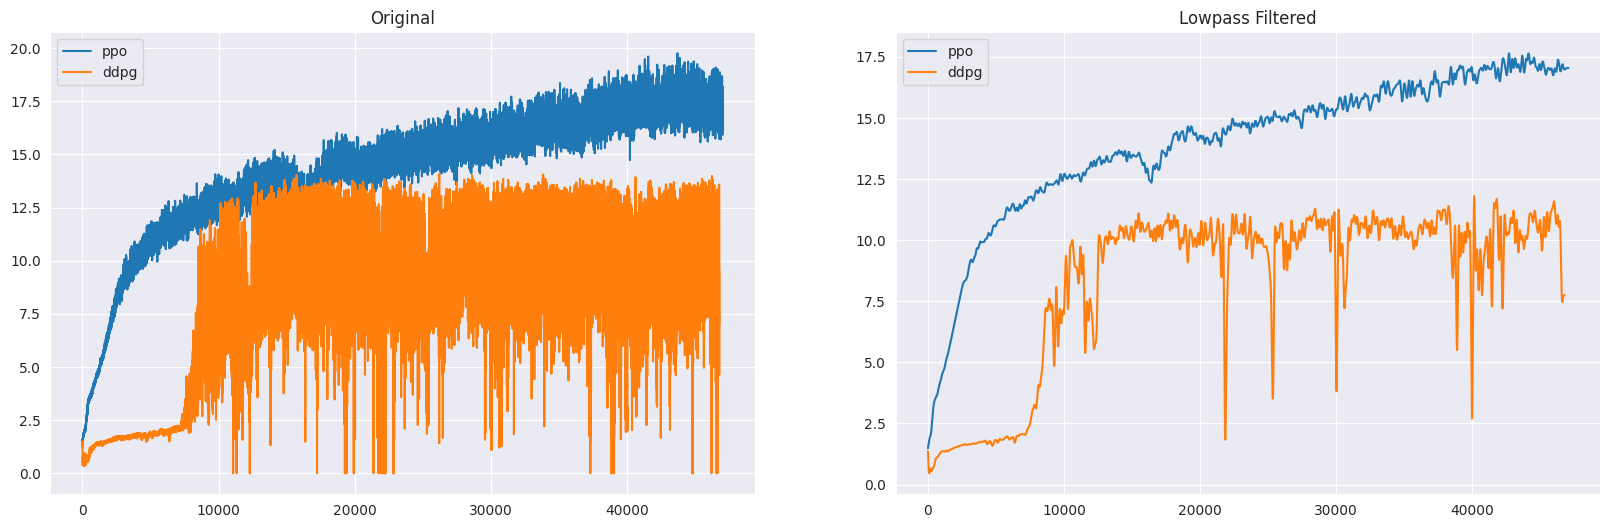

In [174]:

# Plot the first curve before and after lowpass filtering
# curve = ep_rew_clean[ep_rew_clean['seed'] == '37']['value'].values
# lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)

ppo_curve = all_df[(all_df['algo'] == 'ppo') & (all_df['seed'] == '37')]['episode_reward'].values

ddpg_curve = all_df[(all_df['algo'] == 'ddpg') & (all_df['seed'] == '37')]['episode_reward'].values

low_pass_ppo_curve = lowpass_filter(ppo_curve, lowpass_thresh=0.01)
low_pass_ddpg_curve = lowpass_filter(ddpg_curve, lowpass_thresh=0.01)

# plot both curves with the original on the left, and lowpass on the right
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(ppo_curve)
axes[0].plot(ddpg_curve)
axes[0].set_title('Original')
axes[1].plot(low_pass_ppo_curve)
axes[1].plot(low_pass_ddpg_curve)
axes[1].set_title('Lowpass Filtered')

#add a legend so it's easy to read
axes[0].legend(['ppo', 'ddpg'])
axes[1].legend(['ppo', 'ddpg'])


In [176]:
# For each algo, compute a new df with the lowpass filtered curves
lowpass_df = pd.DataFrame()
for algo in algo_to_exp_dict.keys():
    algo_df = all_df[all_df['algo'] == algo]
    for seed, group in algo_df.groupby('seed'):
        curve = group['episode_reward'].values
        lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)
        group['lowpass_episode_reward'] = lowpass_curve
        lowpass_df = pd.concat([lowpass_df, group])

<Axes: xlabel='step', ylabel='lowpass_episode_reward'>

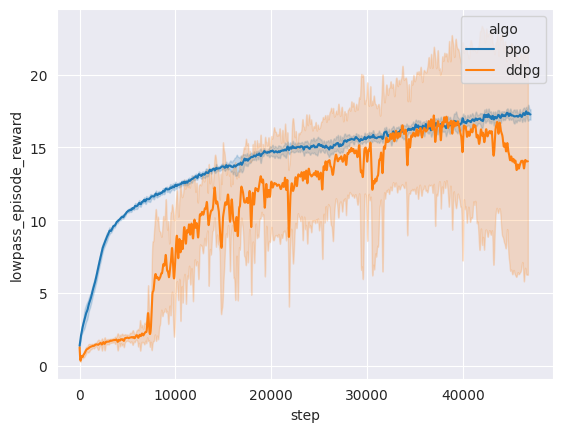

In [178]:
# plot both algorithms but group by the seeds to get mean and standard deviation
sns.lineplot(x='step', y='lowpass_episode_reward', hue='algo', data=lowpass_df, errorbar='sd')

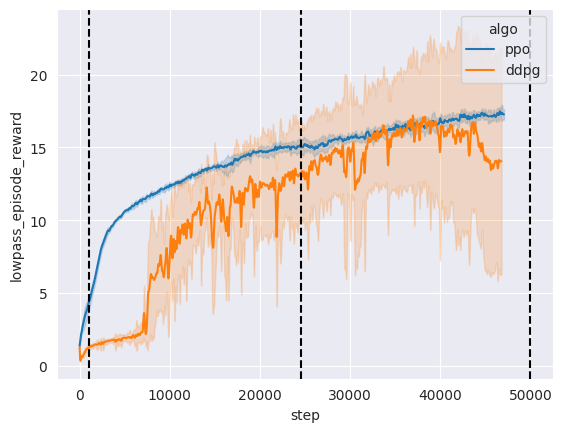

In [184]:
# draw the same graphs again but with vertical lines at three distinct locations for "easy", "medium", and "hard"
beginner = 1000
expert = 50000
medium = (expert - beginner) // 2
x = sns.lineplot(x='step', y='lowpass_episode_reward', hue='algo', data=lowpass_df, errorbar='sd')
for loc in (beginner, medium, expert):
    x.axvline(loc, color='black', linestyle='--')


In [235]:
# Assuming lowpass_df is your DataFrame and algo_to_exp_dict is your dictionary of algorithms

for algo in algo_to_exp_dict.keys():
    algo_df = lowpass_df[lowpass_df['algo'] == algo]
    
    # Assuming the columns you want to compute IQR for are everything but the 'algo' column
    columns_to_compute = [col for col in algo_df.columns if col != 'algo']
    
    iqr_values = {}
    for col in columns_to_compute:
        iqr = scipy.stats.iqr(algo_df[col].values)
        iqr_values[col] = iqr

    print(f'Algo: {algo}')
    for col, iqr in iqr_values.items():
        print(f'Column: {col}, IQR: {iqr}')
    print('-' * 50)  # A separator for easier reading


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [236]:
algo_df[col].values

array(['14', '14', '14', ..., '98', '98', '98'], dtype=object)

## System Metrics

In [187]:
# Load all of the system metrics using glob and pandas csv

system_metric_dirs = []

for algo in algo_to_exp_dict.keys():
    experiment_path = os.path.join(experiment_base_dir, algo, algo_to_exp_dict[algo],
                                   f'**/train_emissions.csv')
    print(f'Experiment Path: {experiment_path}')

    system_metric_dirs.extend(glob.glob(experiment_path, recursive=True))

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/**/train_emissions.csv


In [188]:
len(system_metric_dirs)

12

In [207]:
# Get the system metrics for each run
system_metrics_df = pd.DataFrame()

for metric_dir in system_metric_dirs:
    split_dir = metric_dir.split('/')
    exp_name = split_dir[-3]
    exp_name_split = exp_name.split('_')
    print(exp_name_split)
    seed = exp_name_split[-5]
    experiment = split_dir[-4]
    algo = split_dir[-5]
    
    print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')
    
    df = pd.read_csv(metric_dir)
    df['seed'] = seed
    df['experiment'] = experiment
    df['algo'] = algo
    
    system_metrics_df = pd.concat([system_metrics_df, df])


['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '65', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 65, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '14', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 14, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '37', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 37, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '23', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 23, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '82', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 82, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'f

In [215]:
mean_duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].mean()
std_duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].std()

# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    # make into hours please
    mean_duration[algo] /= 3600
    std_duration[algo] /= 3600
    print(f'Algo: {algo}, Mean Duration: {mean_duration[algo]} +/- {std_duration[algo]}')

Algo: ppo, Mean Duration: 9.28810767141757 +/- 0.32456648285903517
Algo: ddpg, Mean Duration: 15.494186520013544 +/- 0.21334370520891233


In [ ]:
duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].mean()

In [229]:
# Let's see the mean and standard deviation of the peak ram usage. we'll need to take the max of the process_ram column
mean_peak_ram = system_metrics_df.groupby(['algo', 'seed'])['ram_process'].max().groupby('algo').mean()
std_peak_ram = system_metrics_df.groupby(['algo', 'seed'])['ram_process'].max().groupby('algo').std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean Peak RAM: {mean_peak_ram[algo]} +/- {std_peak_ram[algo]}')

Algo: ppo, Mean Peak RAM: 132.40590540568033 +/- 0.021790319406040145
Algo: ddpg, Mean Peak RAM: 474.8679993947347 +/- 0.42848573579269467


In [232]:
# Get the average ram usage for each algo
mean_ram = system_metrics_df.groupby('algo')['ram_process'].mean()
std_ram = system_metrics_df.groupby('algo')['ram_process'].std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean RAM: {mean_ram[algo]} +/- {std_ram[algo]}')

Algo: ppo, Mean RAM: 132.3020228140673 +/- 1.710937104588233
Algo: ddpg, Mean RAM: 357.2859432333534 +/- 89.53247248389125


# Inferece Metrics


## Reliability Metrics

##  System Metrics

In [23]:
system_metric_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '', task)

for algo in algo_to_exp_dict.keys():
    experiment_path = os.path.join(experiment_base_dir, algo, algo_to_exp_dict[algo],
                                   f'**/inference_emissions.csv')
    print(f'Experiment Path: {experiment_path}')

    system_metric_dirs.extend(glob.glob(experiment_path, recursive=True))
len(system_metric_dirs)

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/**/inference_emissions.csv


6

In [24]:
print(system_metric_dirs)

['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/metrics/dog_pace/inference_emissions.csv', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/metrics/dog_pace/inference_emissions.csv', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_37_total_env_steps_200000000/metrics/dog_pace/inference_emissions.csv', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_23_total_env_steps_200000000/metrics/dog_pace/inference_emissions.csv', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/quadruped_locomotion_int_save_freq_1000000_parallel_c

In [20]:
# Get the system metrics for each run
system_metrics_df = pd.DataFrame()

for metric_dir in system_metric_dirs:
    split_dir = metric_dir.split('/')
    exp_name = split_dir[-4]
    exp_name_split = exp_name.split('_')
    print(exp_name_split)
    seed = exp_name_split[-5]
    experiment = split_dir[-5]
    algo = split_dir[-6]

    print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

    df = pd.read_csv(metric_dir)
    df['seed'] = seed
    df['experiment'] = experiment
    df['algo'] = algo

    system_metrics_df = pd.concat([system_metrics_df, df])

['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '65', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 65, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '14', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 14, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '37', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 37, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '23', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 23, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '82', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0006, Seed: 82, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'f

In [21]:
mean_duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].mean()
std_duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].std()

In [22]:
mean_duration

algo
ppo    16.292763
Name: duration, dtype: float64

In [13]:
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    # make into hours please
    mean_duration[algo] /= 3600
    std_duration[algo] /= 3600
    print(f'Algo: {algo}, Mean Duration: {mean_duration[algo]} +/- {std_duration[algo]}')


KeyError: 'ppo'

In [10]:

duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].mean()
# Let's see the mean and standard deviation of the peak ram usage. we'll need to take the max of the process_ram column
mean_peak_ram = system_metrics_df.groupby(['algo', 'seed'])['ram_process'].max().groupby('algo').mean()
std_peak_ram = system_metrics_df.groupby(['algo', 'seed'])['ram_process'].max().groupby('algo').std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean Peak RAM: {mean_peak_ram[algo]} +/- {std_peak_ram[algo]}')
# Get the average ram usage for each algo
mean_ram = system_metrics_df.groupby('algo')['ram_process'].mean()
std_ram = system_metrics_df.groupby('algo')['ram_process'].std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean RAM: {mean_ram[algo]} +/- {std_ram[algo]}')

['',
 'home',
 'ikechukwuu',
 'workspace',
 'gcs',
 'a2perf',
 'quadruped_locomotion',
 'dog_pace',
 'ppo',
 '0006',
 'quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000',
 'metrics',
 'dog_pace',
 'inference_emissions.csv']